# Solving k-SAT problems with Grover's and Schöning's Algorithms

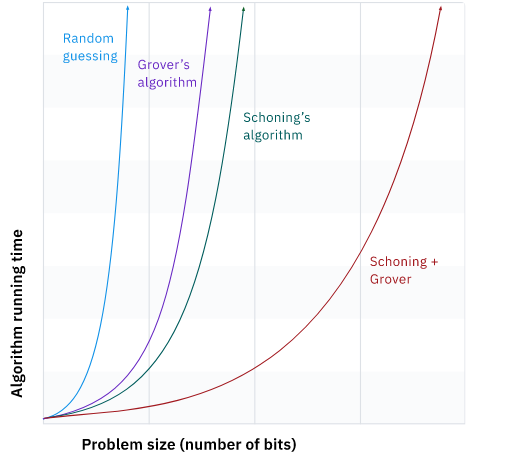
Image Source: [Qiskit Tutorial](https://learn.qiskit.org/course/introduction/grovers-search-algorithm)

## Introduction
In this notebook, I present you three (actually, even more) approaches to SAT problems. These are classical Schoening's algorithm, quantum Grover's algorithm, and a combination of the two. Of course, the main purpose, to my mind, was to shed some light on the combined approach, as the first two are generally mainstream. For the proposed 9-SAT problem, with Grover, we can solve it in 3-4 quantum oracle queries, while with the combined approach we only need one and then one additional classical algorithm iteration. This sounds quite inspiring, however, the resulting quantum oracle that we use in the latter is implemented so computationally hard that the method becomes, to my mind, unusable. Surely, if we do not take the insides of the oracle to account, then such a method is overwhelmingly efficient. An alternative combined approach which is to apply Grover's search to the space of random seeds is much better in any case.

If you want to read more on what SAT problems are, you can do it [on Wikipedia](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem). SAT problems are basically systems of logical statements.

This notebook can obviously be used as a tutorial for combining Schoening's and Grover's methods, if the reader is aware of the Grover's Algorithm and 3-SAT (k-SAT) problems.

In [1]:
# load SAT problem data
# we use the dimacs format

SATfilename = '9sat.dimacs'
with open(SATfilename, 'r', encoding='utf8') as f:
    dimacs = f.read()
print(dimacs)

c example DIMACS-CNF 9-SAT
p cnf 9 8
-1 0
2 0
3 0
4 0
5 0
6 0
7 8 0
-9 -8 0



The standard way to represent a Boolean formula in conjunctive normal form is the DIMACS format. The
format is used as input to modern SAT-solvers. A file in the DIMACS format begins with a line specifying
that the formula is in normal form, the number of variables in the formula, and how many clauses it contains.
For example, `p cnf 4 3` specifies that the file contains a formula in conjunctive normal form with 4 variables
and 3 clauses. Then, the next lines describe the clauses, one on each line. Each line contains a list of positive
or negative integers, and ends with a zero. A positive integer i indicates that the ith variable appears in the
clause, whereas a negative integer -i indicates that the negation of the ith variable appears in the clause.

[Source](https://ifm97.github.io/assignments/SAT-solver.pdf)

In [2]:
# extract the problem from the .dimacs file
clauses = []
varn, clsn = None, None
for line in dimacs.split('\n'):
    ls = line.split()
    if not ls or ls[0] == 'c':
        continue
    elif ls[0] == 'p':
        if ls[1] == 'cnf':
            varn, clsn = int(ls[2]), int(ls[3])
        else:
            print('Unknown problem type')
            break
    else:
        clauses.append([int(i) for i in ls[:-1]])

In [3]:
def test(binvec, clause):
    for i in range(len(clause)):
        bit = binvec[abs(clause[i])-1]
        if clause[i] < 0:
            if not bit:
                return True
        else:
            if bit:
                return True
    return False

def check(binvec, clauses):
    return [test(binvec, clause) for clause in clauses]

In [4]:
# count solutions explicitly

solutions = 0
for inp in range(2**varn):
    bvec = [0 for _ in range(varn)]
    k = 0
    for bit in bin(inp)[-1:1:-1]:
        bvec[k] = int(bit)
        k += 1
    solutions += int(sum(check(bvec, clauses))/clsn)
solutions

4

If you are going to play around with this notebook, I strongly suggest the number of solutions for your SAT problem to be less than a half of the number of possible inputs. That is because Grover's search may (in fact, it almost certainly will) fail otherwise.

## Schöning's Algorithm Solution

In [5]:
import random as rnd

In [6]:
def schoening_iter(binvec, clauses) -> list:
    n = len(binvec)
    clsn = len(clauses)
    for __ in range(3*n):
        state = check(binvec, clauses)
        for i in range(clsn):
            if not state[i]:
                nbinvec = binvec.copy()
                while not test(nbinvec, clauses[i]):
                    idx = rnd.randint(0, n-1)
                    nbinvec[idx] = not nbinvec[idx]
                binvec = nbinvec
                break
    return binvec

In [7]:
# solution
binvec = [rnd.choice((0,1)) for _ in range(varn)]

for _ in range(int((4/3)**varn)):
    binvec = schoening_iter(binvec, clauses)

In [8]:
# check the solution
print(check(binvec, clauses))
print(binvec)

[True, True, True, True, True, True, True, True]
[False, True, True, True, True, True, True, True, False]


## Grover's Algorithm Solution

In [9]:
from qiskit.circuit.library import PhaseOracle
oracle = PhaseOracle.from_dimacs_file(SATfilename)
oracle.draw()

q_0: ─o──o─
      │  │ 
q_1: ─■──■─
      │  │ 
q_2: ─■──■─
      │  │ 
q_3: ─■──■─
      │  │ 
q_4: ─■──■─
      │  │ 
q_5: ─■──■─
      │  │ 
q_6: ─■──┼─
      │  │ 
q_7: ─o──■─
         │ 
q_8: ────o─

In [10]:
from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)

In [11]:
from qiskit import QuantumCircuit
init = QuantumCircuit(varn)
init.h(list(range(varn)))
init.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     ├───┤
q_6: ┤ H ├
     ├───┤
q_7: ┤ H ├
     ├───┤
q_8: ┤ H ├
     └───┘

In [12]:
from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)
qc = init.compose(grover_operator)
for _ in range(int(round(3.14/4*2**(varn/2)/solutions)-1)):
    qc = qc.compose(grover_operator)
qc.measure_all()
qc.draw()

┌───┐┌────┐┌────┐┌────┐┌────┐ ░ ┌─┐                        
   q_0: ┤ H ├┤0   ├┤0   ├┤0   ├┤0   ├─░─┤M├────────────────────────
        ├───┤│    ││    ││    ││    │ ░ └╥┘┌─┐                     
   q_1: ┤ H ├┤1   ├┤1   ├┤1   ├┤1   ├─░──╫─┤M├─────────────────────
        ├───┤│    ││    ││    ││    │ ░  ║ └╥┘┌─┐                  
   q_2: ┤ H ├┤2   ├┤2   ├┤2   ├┤2   ├─░──╫──╫─┤M├──────────────────
        ├───┤│    ││    ││    ││    │ ░  ║  ║ └╥┘┌─┐               
   q_3: ┤ H ├┤3   ├┤3   ├┤3   ├┤3   ├─░──╫──╫──╫─┤M├───────────────
        ├───┤│    ││    ││    ││    │ ░  ║  ║  ║ └╥┘┌─┐            
   q_4: ┤ H ├┤4 Q ├┤4 Q ├┤4 Q ├┤4 Q ├─░──╫──╫──╫──╫─┤M├────────────
        ├───┤│    ││    ││    ││    │ ░  ║  ║  ║  ║ └╥┘┌─┐         
   q_5: ┤ H ├┤5   ├┤5   ├┤5   ├┤5   ├─░──╫──╫──╫──╫──╫─┤M├─────────
        ├───┤│    ││    ││    ││    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
   q_6: ┤ H ├┤6   ├┤6   ├┤6   ├┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
        ├───┤│    ││    ││    ││    │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_7: ┤ H ├┤7   ├┤7   ├┤7   ├┤7   ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤│    ││    ││    ││    │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_8: ┤ H ├┤8   ├┤8   ├┤8   ├┤8   ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘└────┘└────┘└────┘└────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 9/═════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                         0  1  2  3  4  5  6  7  8

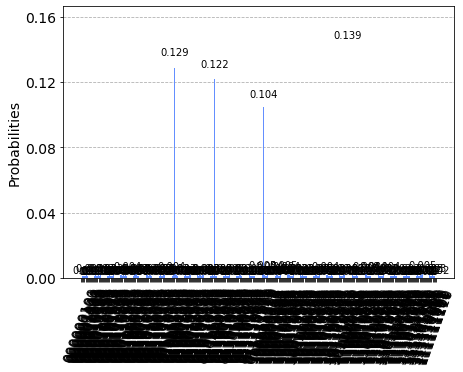

In [13]:
# simulate the circuit
from qiskit import Aer, transpile
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [14]:
counts

{'000100110': 1,
 '101011110': 1,
 '011001101': 2,
 '010111001': 1,
 '000001101': 1,
 '111001010': 1,
 '001010100': 1,
 '000000101': 1,
 '101100111': 1,
 '011110001': 1,
 '001110101': 1,
 '100100100': 1,
 '111011011': 1,
 '110010111': 1,
 '101110111': 2,
 '010110001': 1,
 '011110101': 1,
 '001001000': 1,
 '010001010': 2,
 '100001000': 1,
 '001100101': 1,
 '001101000': 1,
 '111001100': 1,
 '100010110': 2,
 '110010011': 1,
 '011011001': 1,
 '011110011': 1,
 '111001110': 1,
 '110001101': 3,
 '100100000': 2,
 '011011110': 1,
 '101011010': 2,
 '010110111': 1,
 '001001010': 1,
 '110001111': 1,
 '010010100': 1,
 '010101100': 1,
 '110110111': 2,
 '100111010': 1,
 '101011100': 2,
 '010100000': 1,
 '111101111': 2,
 '100110111': 1,
 '110111011': 1,
 '000010100': 1,
 '111101010': 1,
 '010001110': 1,
 '000010010': 1,
 '111101011': 1,
 '100111111': 1,
 '000001001': 1,
 '110100110': 1,
 '001110111': 1,
 '101000001': 1,
 '000001100': 1,
 '011010111': 1,
 '001101111': 2,
 '101010110': 1,
 '100101011': 

In [15]:
# search for a binary string with maximal counts
m = 0
solvec = None
for binvec in counts:
    if counts[binvec] > m:
        solvec = binvec
        m = counts[binvec]
del m
solvec = [int(b) for b in reversed(solvec)]

# check the solution
print(check(solvec, clauses))
print(solvec)

[True, True, True, True, True, True, True, True]
[0, 1, 1, 1, 1, 1, 1, 0, 1]


## Combined Solution #1
The idea is to use Grover's algorithm to search for the best initial guess that will allow us to solve the problem in only one Schoening's algorithm iteration.

In [16]:
# naїvely cache all the inputs' outcomes for the Schoening's algo
# we also count schoening_cache_ones along the way 
# this is only to construct the oracle

schoening_cache = {}
schoening_cache_ones = 0
for inp in range(2**varn):
    bvec = [0 for _ in range(varn)]
    k = 0
    for bit in bin(inp)[-1:1:-1]:
        bvec[k] = int(bit)
        k += 1
    result = int(sum(check(schoening_iter(bvec, clauses), clauses))/clsn)
    schoening_cache[tuple(bvec)] = result
    schoening_cache_ones += result

if schoening_cache_ones == 2**varn:
    raise Exception("The problem is too easy. Schoening's algorithm succeeds in 1 iteration for all possible initial values. PhaseOracle construction will fail")

In [17]:
# construct a binary logical expression (formula) that describes our database
# we will construct the disjunctive normal form of the function

def dnf(func: dict) -> str:
    formula = ''
    for vec in func:
        if func[vec]:
            formula += '('
            for biti in range(len(vec)):
                if not vec[biti]:
                    formula += '~'
                formula += f"v{biti}"
                if biti < len(vec)-1:
                    formula += '&'
            formula += ')|'
    return formula[:-1]
    
schoening_oracle_formula = dnf(schoening_cache)

#schoening_oracle_formula # this formula can be large so we better not look at it

In [18]:
# build the oracle
oracle = PhaseOracle(schoening_oracle_formula)
oracle.draw()

»
q_0: ─■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_1: ─o──o──o──o──■──o──o──o──o──o──o──o──o──o──o──■──o──o──┼──┼──┼──o──o──┼─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_2: ─■──■──■──■──■──■──o──o──o──o──■──o──o──o──o──o──o──o──■──■──o──■──■──■─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_3: ─┼──■──■──■──o──o──■──■──■──■──■──┼──┼──┼──┼──┼──┼──┼──o──o──o──■──o──┼─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_4: ─o──■──┼──┼──┼──■──o──o──┼──┼──o──■──■──■──┼──┼──┼──┼──o──o──┼──┼──■──■─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_5: ─■──┼──o──┼──o──o──┼──┼──o──┼──■──■──o──┼──■──■──┼──┼──■──o──┼──■──■──o─»
      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
q_6: ─┼──■──┼──o──┼──■──■──o──o──┼──o──┼──┼──■──■──o──■──o──o──o──■──■──┼──■─»
      │  │  │  │  │     │  │     │  │  │  │  │  │     │  │  │     │  │  │    »
q_7: ─■──o──■──■──■─────o──┼─────■──o──o──■──┼──■─────■──■──o─────■──o──■────»
      │     │  │           │     │     │     │        │     │        │  │    »
q_8: ─■─────■──o───────────o─────o─────■─────o────────■─────o────────■──o────»
                                                                             »
«                                                                             »
«q_0: ─■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──■──o──o──o──o──o──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_1: ─┼──o──┼──┼──o──┼──┼──┼──┼──┼──┼──┼──o──┼──┼──o──┼──┼──■──o──o──o──o──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_2: ─■──┼──■──■──o──■──■──■──┼──┼──┼──┼──o──┼──┼──■──┼──┼──■──■──■──■──■──┼─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_3: ─┼──o──┼──┼──┼──┼──┼──o──o──o──o──o──■──o──■──■──o──┼──■──■──■──■──┼──■─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_4: ─■──o──■──┼──┼──┼──┼──o──o──o──■──┼──┼──┼──┼──o──┼──■──o──■──o──┼──■──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_5: ─o──┼──┼──■──■──o──o──■──o──o──┼──o──┼──o──o──┼──┼──o──┼──■──o──■──o──┼─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_6: ─┼──■──┼──■──o──■──o──■──■──┼──┼──o──o──■──┼──┼──┼──o──■──o──┼──┼──■──┼─»
«      │     │  │  │  │  │     │  │  │  │  │  │  │  │  │     │  │  │  │  │  │ »
«q_7: ─■─────┼──o──o──┼──o─────┼──■──■──o──o──┼──■──■──o─────■──■──┼──■──■──■─»
«            │     │  │  │     │     │        │                    │  │     │ »
«q_8: ───────■─────■──o──■─────o─────o────────■────────────────────■──o─────■─»
«                                                                             »
«                                                                             »
«q_0: ─o──■──o──o──o──o──o──o──o──o──■──o──■──o──o──o──■──■──o──■──o──o──■──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_1: ─■──┼──o──o──■──o──■──■──■──o──o──o──o──o──o──o──┼──┼──o──o──■──o──o──■─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_2: ─o──■──■──┼──o──■──o──■──■──┼──o──┼──o──┼──┼──┼──┼──┼──■──■──■──┼──■──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_3: ─┼──o──┼──■──■──┼──■──┼──o──■──■──■──┼──■──┼──┼──┼──┼──┼──■──■──■──o──┼─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_4: ─┼──■──o──o──■──┼──■──┼──┼──o──o──o──■──┼──┼──o──■──┼──┼──┼──o──┼──■──┼─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_5: ─┼──■──■──o──┼──o──o──┼──o──■──■──■──■──┼──■──┼──┼──┼──┼──■──■──■──┼──o─»
«      │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │  │ »
«q_6: ─o──o──┼──

In [19]:
init = QuantumCircuit(varn)
init.h(list(range(varn)))
grover_operator = GroverOperator(oracle)
qc = init.compose(grover_operator)
for _ in range(int(round(3.14/4*(4/3)**(varn/2)/schoening_cache_ones))-1):
    qc = qc.compose(grover_operator)
qc.measure_all()
qc.draw()

# even though the oracle can be huge, we only need to query it once for this 9SAT problem

┌───┐┌────┐ ░ ┌─┐                        
   q_0: ┤ H ├┤0   ├─░─┤M├────────────────────────
        ├───┤│    │ ░ └╥┘┌─┐                     
   q_1: ┤ H ├┤1   ├─░──╫─┤M├─────────────────────
        ├───┤│    │ ░  ║ └╥┘┌─┐                  
   q_2: ┤ H ├┤2   ├─░──╫──╫─┤M├──────────────────
        ├───┤│    │ ░  ║  ║ └╥┘┌─┐               
   q_3: ┤ H ├┤3   ├─░──╫──╫──╫─┤M├───────────────
        ├───┤│    │ ░  ║  ║  ║ └╥┘┌─┐            
   q_4: ┤ H ├┤4 Q ├─░──╫──╫──╫──╫─┤M├────────────
        ├───┤│    │ ░  ║  ║  ║  ║ └╥┘┌─┐         
   q_5: ┤ H ├┤5   ├─░──╫──╫──╫──╫──╫─┤M├─────────
        ├───┤│    │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐      
   q_6: ┤ H ├┤6   ├─░──╫──╫──╫──╫──╫──╫─┤M├──────
        ├───┤│    │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
   q_7: ┤ H ├┤7   ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├───
        ├───┤│    │ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
   q_8: ┤ H ├┤8   ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
        └───┘└────┘ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
meas: 9/═══════════════╩══╩══╩══╩══╩══╩══╩══╩══╩═
                       0  1  2  3  4  5  6  7  8

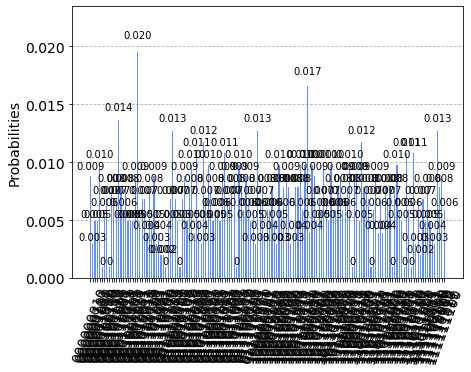

In [20]:
# simulate the circuit
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
plot_histogram(counts)
# here our quantum search algorithm may find only the INCORRECT solutions because there are fewer of them...

In [21]:
# ... so we search for a binary string with maximal counts or minimal counts depending on schoening_cache_ones
initial_vec = None
if schoening_cache_ones < (2**varn - schoening_cache_ones):
    m = 0
    for binvec in counts:
        if counts[binvec] > m:
            initial_vec = binvec
            m = counts[binvec]
else:
    m = float("Inf")
    for binvec in counts:
        if counts[binvec] < m:
            initial_vec = binvec
            m = counts[binvec]

initial_vec = [int(b) for b in reversed(initial_vec)]

In [22]:
# solution
binvec = initial_vec

binvec = schoening_iter(binvec, clauses)

In [23]:
# check the solution
print(check(binvec, clauses))
print(binvec)

[True, True, True, True, True, True, True, True]
[False, True, True, True, True, True, True, False, False]


## Combined Solution #2
Another idea is to apply Grover's search not to the space of possible input bitstrings but to the space of random seeds instead. We can then use the found seed to generate an initial bitstrings for the Schoening's algorithm. Here, ideally, we would need to mathematically choose the seed space enough for the Schoening's step to succeed, yet there is some space to reduce the number of qubits.

In [24]:
n_qubits = 3

In [25]:
# naїvely cache all the seeds

schoening_seeds = {}
schoening_seeds_ones = 0
n_seeds = 2**n_qubits
for seed in range(n_seeds):
    rnd.seed(a=seed)
    bvec = [rnd.choice((0,1)) for _ in range(varn)]
    
    svec = [0 for _ in range(n_qubits)]
    k = 0
    for bit in bin(seed)[-1:1:-1]:
        svec[k] = int(bit)
        k += 1
    result = int(sum(check(schoening_iter(bvec, clauses), clauses))/clsn)
    schoening_seeds[tuple(svec)] = result
    schoening_seeds_ones += result
    
if schoening_seeds_ones == 2**n_qubits:
    raise Exception("The problem is too easy. Schoening's algorithm succeeds in 1 iteration for all possible seed values. PhaseOracle construction will fail")
    
schoening_seeds

{(0, 0, 0): 1,
 (1, 0, 0): 1,
 (0, 1, 0): 1,
 (1, 1, 0): 1,
 (0, 0, 1): 1,
 (1, 0, 1): 0,
 (0, 1, 1): 1,
 (1, 1, 1): 1}

In [26]:
schoening_seeds_formula = dnf(schoening_seeds)

schoening_seeds_formula

'(~v0&~v1&~v2)|(v0&~v1&~v2)|(~v0&v1&~v2)|(v0&v1&~v2)|(~v0&~v1&v2)|(~v0&v1&v2)|(v0&v1&v2)'

In [27]:
# build the oracle
oracle = PhaseOracle(schoening_seeds_formula)
oracle.draw()

q_0: ────────────────o────
                     │    
q_1: ────────────────o──■─
     ┌───┐┌───┐┌───┐ │  │ 
q_2: ┤ X ├┤ Z ├┤ X ├─■──■─
     └───┘└───┘└───┘

In [28]:
init = QuantumCircuit(n_qubits)
init.h(list(range(n_qubits)))
grover_operator = GroverOperator(oracle)
qc = init.compose(grover_operator)
for _ in range(int(round(3.14/4*(4/3)**(n_qubits/2)/schoening_cache_ones))):
    qc = qc.compose(grover_operator)
qc.measure_all()
qc.draw()

┌───┐┌────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0   ├─░─┤M├──────
        ├───┤│    │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 Q ├─░──╫─┤M├───
        ├───┤│    │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2   ├─░──╫──╫─┤M├
        └───┘└────┘ ░  ║  ║ └╥┘
meas: 3/═══════════════╩══╩══╩═
                       0  1  2

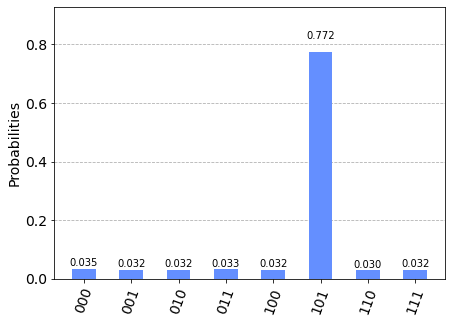

In [29]:
# simulate the circuit
sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, sim)
counts = sim.run(t_qc).result().get_counts()

# plot the results
plot_histogram(counts)
# here our quantum search algorithm finds the INCORRECT solutions because there are fewer of them...

In [30]:
# ... so we search for a binary string with MINIMAL counts
m = float("Inf")
a = None
for binvec in counts:
    if counts[binvec] < m:
        a = binvec
        m = counts[binvec]
del m
rnd.seed(a=int(a, base=2))
bvec = [rnd.choice((0,1)) for _ in range(varn)]
bvec = schoening_iter(bvec, clauses)

print(check(bvec, clauses))
bvec

[True, True, True, True, True, True, True, True]


[False, True, True, True, True, True, True, False, True]

## Conclusion
As a conclusion, I offer you the following statement: Grover's search algorithm (amplitude amplification) can be applied to seed spaces of classical randomized algorithms to boost their perfomance.

## Sources
Even though this algorithm (combined Schöning's and Grover's approaches) is quite frequently mentioned, I haven't found its implementation, detailed description, or pseudocode anywhere. In fact, I only used the following sources and simply derived everything myself using those descriptions. Frankly, this was all quite intuitive and I haven't proven resulting algorithms formally, so there can be some mistakes (if so, please let me know).
1) [Notes on the Classical Schöning's Algorithm](http://cs.yale.edu/homes/spielman/365/schoening.pdf)

2) [A Particularly Useful StackExchange Question](https://quantumcomputing.stackexchange.com/questions/14293/grovers-search-applied-to-sch%C3%B6nings-algorithm)

3) [Qiskit Tutorial on Grover's Algorithm](https://learn.qiskit.org/course/introduction/grovers-search-algorithm), specifically, this paragraph:

"It may not be obvious at first glance, but we can actually combine Grover and Schöning's algorithms to get something even better than either individually. If you create a circuit that carries out the bit-toggling part of Schöning's algorithm, you can use this as the oracle and use Grover's algorithm to find the best "initial guess"."

4) [Another Qiskit Tutorial on Gorver's Algorithm](https://qiskit.org/textbook/ch-algorithms/grover.html)